### import os
import shutil

Importing Packages

In [1]:
import os 
import glob
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage.io import imread,imsave
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import save_model, load_model, Model
from tensorflow.keras.layers import Input,InputLayer, Dropout, Flatten, Dense, Activation, MaxPooling2D, Conv2D
from sklearn.metrics import classification_report

In [2]:
root='/blue/oguzhan/swetha.lenkala/AFFINE_REG_SKS_MASK_2D_IMAGES_DIR'

ResNet50 Model with 60 epochs and Learning rate=0.0001

In [3]:
def resnet50_row(optimizer, loss,metrics,shape):
  image_input = tf.keras.applications.ResNet50(include_top=False,weights='imagenet',input_shape=shape)

  for layer in image_input.layers:
      layer.trainable = True
      layer._name = layer._name  + str('_img')

  y = Flatten() (image_input.output)
  c = Dropout(0.4) (y)
  c = Dense(512) (c)
  c = Dense(256) (c)
  c = Dense(128) (c)
  output_layer = Dense(3, activation='softmax')(c)

  model = Model(inputs=image_input.input,outputs=output_layer)
  model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
  return model

In [4]:
def plot_confusion_matrix(true_lab,predict_lab,classes,path):
  matrix_confusion = tf.math.confusion_matrix(labels=true_lab, predictions=predicted_lab, num_classes=len(classes))
  ax = plt.subplot()
  sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=True)
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')
  ax.xaxis.set_ticklabels(classes)
  ax.yaxis.set_ticklabels(classes)
  plt.savefig(f'{path}confusion_matrix.png')
     

In [5]:
def dump_text(text,path):
  text_file = open(path, "w")
  text_file.write(text)
  text_file.close()

In [6]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

2024-04-01 11:29:08.703436: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-01 11:29:09.542933: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9629 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5


In [7]:
image_Shape=(436,364,3)
training_image_datagen = ImageDataGenerator(horizontal_flip=True).flow_from_directory(
                                                  directory=f'{root}/training/',
                                                  target_size=(image_Shape[0], image_Shape[1]),
                                                  class_mode='categorical',
                                                  batch_size=4
                                                  )

testing_image_datagen = ImageDataGenerator().flow_from_directory(
                                                  directory = f'{root}/testing/' ,
                                                  target_size = (image_Shape[0] ,image_Shape[1]) ,
                                                  class_mode = 'categorical' ,
                                                  batch_size=1 ,
                                                  shuffle = False
                                                  )

Found 1901 images belonging to 3 classes.
Found 478 images belonging to 3 classes.


In [8]:
training_image_datagen.class_indices

{'AD': 0, 'CN': 1, 'MCI': 2}

In [8]:

METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='Accuracy'),
    tf.keras.metrics.Precision(name='AD_Precision',class_id=0),
    tf.keras.metrics.Precision(name='CN_Precision',class_id=1),
    tf.keras.metrics.Precision(name='MCI_Precision',class_id=2),
    tf.keras.metrics.Recall(name='AD_Recall',class_id=0),
    tf.keras.metrics.Recall(name='CN_Recall',class_id=1),
    tf.keras.metrics.Recall(name='MCI_Recall',class_id=2),
    ]
LOOS = 'categorical_crossentropy'

2024-04-01 11:29:17.659285: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9629 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5


In [10]:
# learning_rate=10E-5
savepath = 'models'
lr=0.0001
if not os.path.isdir(savepath):
      os.makedirs(savepath)
csvloger_callback = tf.keras.callbacks.CSVLogger(f'{savepath}history.csv', separator=',', append=False)

modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(savepath+'resnet50_row_10E-5_weights-epoch:{epoch:03d}-val_Accuracy:{val_Accuracy:.4f}.h5',monitor='val_Accuracy'
    ,verbose=0,save_best_only=True,save_weights_only=True,mode='max',save_freq='epoch' , initial_value_threshold=0.85)

OPT = tf.keras.optimizers.Adam(learning_rate=lr)
model05 = resnet50_row(OPT, LOOS,METRICS,image_Shape)
history05 = model05.fit(training_image_datagen, epochs=EPOCH, validation_data=testing_image_datagen,callbacks=[csvloger_callback,modelcheckpoint_callback])
model05 = resnet50_row(OPT, LOOS,METRICS,image_Shape)
model05.load_weights(glob.glob(f"{savepath}resnet50_row_10E-5_weights-epoch:*-val_Accuracy:{max(history05.history['val_Accuracy']):.4f}.h5")[0])
model05.save(f"{savepath}/Resnet_60_0.0001.h5")

Epoch 1/60


2024-02-23 11:05:02.697168: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


476/476 [==============================] - 68s 116ms/step - loss: 7.1332 - Accuracy: 0.5239 - AD_Precision: 0.3440 - CN_Precision: 0.4212 - MCI_Precision: 0.6292 - AD_Recall: 0.2922 - CN_Recall: 0.3786 - MCI_Recall: 0.6328 - val_loss: 1.5720 - val_Accuracy: 0.4798 - val_AD_Precision: 0.4889 - val_CN_Precision: 0.4301 - val_MCI_Precision: 0.6371 - val_AD_Recall: 0.2245 - val_CN_Recall: 0.7452 - val_MCI_Recall: 0.3305
Epoch 2/60
476/476 [==============================] - 54s 113ms/step - loss: 1.0826 - Accuracy: 0.6733 - AD_Precision: 0.5684 - CN_Precision: 0.6185 - MCI_Precision: 0.7431 - AD_Recall: 0.4880 - CN_Recall: 0.5981 - MCI_Recall: 0.7381 - val_loss: 1.0799 - val_Accuracy: 0.6518 - val_AD_Precision: 0.8000 - val_CN_Precision: 0.9420 - val_MCI_Precision: 0.6000 - val_AD_Recall: 0.2041 - val_CN_Recall: 0.4140 - val_MCI_Recall: 0.9791
Epoch 3/60
476/476 [==============================] - 57s 119ms/step - loss: 0.9306 - Accuracy: 0.7296 - AD_Precision: 0.6355 - CN_Precision: 0.6958 

In [11]:
model05.save(f"{savepath}/Resnet_60_0.0001.h5")

/apps/tensorflow/2.7.0/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


              precision    recall  f1-score   support

          AD       0.94      0.66      0.78        98
          CN       0.92      0.83      0.87       157
         MCI       0.81      0.96      0.88       239

    accuracy                           0.86       494
   macro avg       0.89      0.82      0.84       494
weighted avg       0.87      0.86      0.86       494



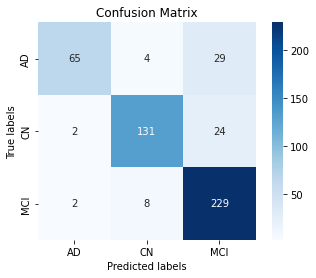

In [12]:
p = model05.predict(testing_image_datagen)
predicted_lab = p.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')

In [13]:
np.save("resnet_60_0.0001.npy",p )

ResNet50 Model with 60 epochs and Learning rate=0.001

In [14]:
def resnet50_row(optimizer, loss,metrics,shape):
  image_input = tf.keras.applications.ResNet50(include_top=False,weights='imagenet',input_shape=shape)

  for layer in image_input.layers:
      layer.trainable = True
      layer._name = layer._name  + str('_img')

  y = Flatten() (image_input.output)
  c = Dropout(0.4) (y)
  c = Dense(512) (c)
  c = Dense(256) (c)
  c = Dense(128) (c)
  output_layer = Dense(3, activation='softmax')(c)

  model = Model(inputs=image_input.input,outputs=output_layer)
  model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
  return model

In [15]:
def plot_confusion_matrix(true_lab,predict_lab,classes,path):
  matrix_confusion = tf.math.confusion_matrix(labels=true_lab, predictions=predicted_lab, num_classes=len(classes))
  ax = plt.subplot()
  sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=True)
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')
  ax.xaxis.set_ticklabels(classes)
  ax.yaxis.set_ticklabels(classes)
  plt.savefig(f'{path}confusion_matrix.png')

In [16]:
def dump_text(text,path):
  text_file = open(path, "w")
  text_file.write(text)
  text_file.close()
     

In [17]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

2024-02-23 13:01:43.777251: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9629 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1b:00.0, compute capability: 7.5


In [18]:
training_image_datagen = ImageDataGenerator(horizontal_flip=True).flow_from_directory(
                                                  directory=f'{root}/training/',
                                                  target_size=(image_Shape[0], image_Shape[1]),
                                                  class_mode='categorical',
                                                  batch_size=4
                                                  )

testing_image_datagen = ImageDataGenerator().flow_from_directory(
                                                  directory = f'{root}/testing/' ,
                                                  target_size = (image_Shape[0] ,image_Shape[1]) ,
                                                  class_mode = 'categorical' ,
                                                  batch_size=1 ,
                                                  shuffle = False
                                                  )

Found 1901 images belonging to 3 classes.
Found 494 images belonging to 3 classes.


In [19]:
EPOCH = 60
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='Accuracy'),
    tf.keras.metrics.Precision(name='AD_Precision',class_id=0),
    tf.keras.metrics.Precision(name='CN_Precision',class_id=1),
    tf.keras.metrics.Precision(name='MCI_Precision',class_id=2),
    tf.keras.metrics.Recall(name='AD_Recall',class_id=0),
    tf.keras.metrics.Recall(name='CN_Recall',class_id=1),
    tf.keras.metrics.Recall(name='MCI_Recall',class_id=2),
    ]
LOOS = 'categorical_crossentropy'

In [21]:
# learning_rate=10E-5
savepath = 'models'
lr=0.001
if not os.path.isdir(savepath):
      os.makedirs(savepath)
csvloger_callback = tf.keras.callbacks.CSVLogger(f'{savepath}history.csv', separator=',', append=False)

modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(savepath+'resnet50_row_10E-5_weights-epoch:{epoch:03d}-val_Accuracy:{val_Accuracy:.4f}.h5',monitor='val_Accuracy'
    ,verbose=0,save_best_only=True,save_weights_only=True,mode='max',save_freq='epoch' , initial_value_threshold=0.85)

OPT = tf.keras.optimizers.Adam(learning_rate=lr)
model02 = resnet50_row(OPT, LOOS,METRICS,image_Shape)
history02 = model02.fit(training_image_datagen, epochs=EPOCH, validation_data=testing_image_datagen,callbacks=[csvloger_callback,modelcheckpoint_callback])
model02 = resnet50_row(OPT, LOOS,METRICS,image_Shape)
model02.load_weights(glob.glob(f"{savepath}resnet50_row_10E-5_weights-epoch:*-val_Accuracy:{max(history02.history['val_Accuracy']):.4f}.h5")[0])
model02.save(f"{savepath}/Resnet_60_0.001.h5")

Epoch 1/60
476/476 [==============================] - 58s 114ms/step - loss: 16.9457 - Accuracy: 0.4892 - AD_Precision: 0.1880 - CN_Precision: 0.2969 - MCI_Precision: 0.5699 - AD_Recall: 0.0753 - CN_Recall: 0.1320 - MCI_Recall: 0.5958 - val_loss: 1.0497 - val_Accuracy: 0.4838 - val_AD_Precision: 0.0000e+00 - val_CN_Precision: 0.0000e+00 - val_MCI_Precision: 0.4805 - val_AD_Recall: 0.0000e+00 - val_CN_Recall: 0.0000e+00 - val_MCI_Recall: 0.9791
Epoch 2/60
476/476 [==============================] - 57s 120ms/step - loss: 1.1001 - Accuracy: 0.5055 - AD_Precision: 0.1463 - CN_Precision: 0.3287 - MCI_Precision: 0.5623 - AD_Recall: 0.0181 - CN_Recall: 0.0913 - MCI_Recall: 0.6082 - val_loss: 1.3054 - val_Accuracy: 0.4838 - val_AD_Precision: 0.0000e+00 - val_CN_Precision: 0.0000e+00 - val_MCI_Precision: 0.4838 - val_AD_Recall: 0.0000e+00 - val_CN_Recall: 0.0000e+00 - val_MCI_Recall: 1.0000
Epoch 3/60
476/476 [==============================] - 52s 108ms/step - loss: 1.0722 - Accuracy: 0.5087 - 

/apps/tensorflow/2.7.0/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


              precision    recall  f1-score   support

          AD       0.81      0.67      0.74        98
          CN       0.80      0.80      0.80       157
         MCI       0.80      0.85      0.82       239

    accuracy                           0.80       494
   macro avg       0.80      0.78      0.79       494
weighted avg       0.80      0.80      0.80       494



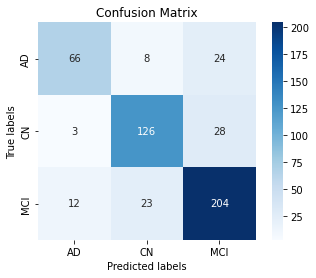

In [22]:
p = model02.predict(testing_image_datagen)
predicted_lab = p.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')

In [23]:
np.save("resnet_60_0.001.npy",p )

Resnet_50 with Epochs 50 and learning rate=0.0001 opt=RMS prop

In [3]:
def resnet50_row(optimizer, loss,metrics,shape):
  image_input = tf.keras.applications.ResNet50(include_top=False,weights='imagenet',input_shape=shape)

  for layer in image_input.layers:
      layer.trainable = True
      layer._name = layer._name  + str('_img')

  y = Flatten() (image_input.output)
  c = Dropout(0.4) (y)
  c = Dense(512) (c)
  c = Dense(256) (c)
  c = Dense(128) (c)
  output_layer = Dense(3, activation='softmax')(c)

  model = Model(inputs=image_input.input,outputs=output_layer)
  model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
  return model

In [4]:
def plot_confusion_matrix(true_lab,predict_lab,classes,path):
  matrix_confusion = tf.math.confusion_matrix(labels=true_lab, predictions=predicted_lab, num_classes=len(classes))
  ax = plt.subplot()
  sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=True)
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')
  ax.xaxis.set_ticklabels(classes)
  ax.yaxis.set_ticklabels(classes)
  plt.savefig(f'{path}confusion_matrix.png')

In [5]:
def dump_text(text,path):
  text_file = open(path, "w")
  text_file.write(text)
  text_file.close()

In [6]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

2024-02-23 15:06:53.780385: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-23 15:06:56.313768: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9629 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1b:00.0, compute capability: 7.5


In [7]:
image_Shape=(436,364,3)
training_image_datagen = ImageDataGenerator(horizontal_flip=True).flow_from_directory(
                                                  directory=f'{root}/training/',
                                                  target_size=(image_Shape[0], image_Shape[1]),
                                                  class_mode='categorical',
                                                  batch_size=4
                                                  )

testing_image_datagen = ImageDataGenerator().flow_from_directory(
                                                  directory = f'{root}/testing/' ,
                                                  target_size = (image_Shape[0] ,image_Shape[1]) ,
                                                  class_mode = 'categorical' ,
                                                  batch_size=1 ,
                                                  shuffle = False
                                                  )

Found 1901 images belonging to 3 classes.
Found 494 images belonging to 3 classes.


In [8]:
EPOCH = 50
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='Accuracy'),
    tf.keras.metrics.Precision(name='AD_Precision',class_id=0),
    tf.keras.metrics.Precision(name='CN_Precision',class_id=1),
    tf.keras.metrics.Precision(name='MCI_Precision',class_id=2),
    tf.keras.metrics.Recall(name='AD_Recall',class_id=0),
    tf.keras.metrics.Recall(name='CN_Recall',class_id=1),
    tf.keras.metrics.Recall(name='MCI_Recall',class_id=2),
    ]
LOOS = 'categorical_crossentropy'

2024-02-23 15:07:34.023462: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9629 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1b:00.0, compute capability: 7.5


In [9]:
# learning_rate=10E-5
savepath = 'models'
lr=0.0001
if not os.path.isdir(savepath):
      os.makedirs(savepath)
csvloger_callback = tf.keras.callbacks.CSVLogger(f'{savepath}history.csv', separator=',', append=False)

modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(savepath+'resnet50_row_10E-5_weights-epoch:{epoch:03d}-val_Accuracy:{val_Accuracy:.4f}.h5',monitor='val_Accuracy'
    ,verbose=0,save_best_only=True,save_weights_only=True,mode='max',save_freq='epoch' , initial_value_threshold=0.85)

OPT = tf.keras.optimizers.RMSprop(learning_rate=lr)
model02 = resnet50_row(OPT, LOOS,METRICS,image_Shape)
history02 = model02.fit(training_image_datagen, epochs=EPOCH, validation_data=testing_image_datagen,callbacks=[csvloger_callback,modelcheckpoint_callback])
model02 = resnet50_row(OPT, LOOS,METRICS,image_Shape)
model02.load_weights(glob.glob(f"{savepath}resnet50_row_10E-5_weights-epoch:*-val_Accuracy:{max(history02.history['val_Accuracy']):.4f}.h5")[0])
model02.save(f"{savepath}/Resnet_60_0.001.h5")

Epoch 1/50


2024-02-23 15:07:52.632361: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


476/476 [==============================] - 83s 141ms/step - loss: 10.1524 - Accuracy: 0.4829 - AD_Precision: 0.2391 - CN_Precision: 0.3553 - MCI_Precision: 0.5761 - AD_Recall: 0.1325 - CN_Recall: 0.2408 - MCI_Recall: 0.5892 - val_loss: 2.1769 - val_Accuracy: 0.4838 - val_AD_Precision: 0.0000e+00 - val_CN_Precision: 0.0000e+00 - val_MCI_Precision: 0.4838 - val_AD_Recall: 0.0000e+00 - val_CN_Recall: 0.0000e+00 - val_MCI_Recall: 1.0000
Epoch 2/50
476/476 [==============================] - 69s 144ms/step - loss: 1.0443 - Accuracy: 0.5450 - AD_Precision: 0.3165 - CN_Precision: 0.5068 - MCI_Precision: 0.6058 - AD_Recall: 0.0753 - CN_Recall: 0.2913 - MCI_Recall: 0.6110 - val_loss: 1.7297 - val_Accuracy: 0.5283 - val_AD_Precision: 1.0000 - val_CN_Precision: 0.8696 - val_MCI_Precision: 0.5075 - val_AD_Recall: 0.0204 - val_CN_Recall: 0.1274 - val_MCI_Recall: 0.9874
Epoch 3/50
476/476 [==============================] - 69s 145ms/step - loss: 0.8690 - Accuracy: 0.6281 - AD_Precision: 0.5393 - CN_P

/apps/tensorflow/2.7.0/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


              precision    recall  f1-score   support

          AD       0.85      0.70      0.77        98
          CN       0.88      0.83      0.86       157
         MCI       0.81      0.90      0.86       239

    accuracy                           0.84       494
   macro avg       0.85      0.81      0.83       494
weighted avg       0.84      0.84      0.84       494



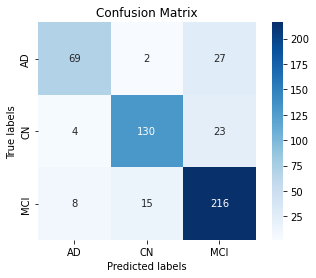

In [10]:
p = model02.predict(testing_image_datagen)
predicted_lab = p.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')

In [11]:
np.save("resnet_60_0.0001.npy",p )

Resnet 50 with epochs=50, learning rate=0.00001 opt=RMS PROP

In [3]:
def resnet50_row(optimizer, loss,metrics,shape):
  image_input = tf.keras.applications.ResNet50(include_top=False,weights='imagenet',input_shape=shape)

  for layer in image_input.layers:
      layer.trainable = True
      layer._name = layer._name  + str('_img')

  y = Flatten() (image_input.output)
  c = Dropout(0.4) (y)
  c = Dense(512) (c)
  c = Dense(256) (c)
  c = Dense(128) (c)
  output_layer = Dense(3, activation='softmax')(c)

  model = Model(inputs=image_input.input,outputs=output_layer)
  model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
  return model

In [4]:
def plot_confusion_matrix(true_lab,predict_lab,classes,path):
  matrix_confusion = tf.math.confusion_matrix(labels=true_lab, predictions=predicted_lab, num_classes=len(classes))
  ax = plt.subplot()
  sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=True)
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')
  ax.xaxis.set_ticklabels(classes)
  ax.yaxis.set_ticklabels(classes)
  plt.savefig(f'{path}confusion_matrix.png')

In [5]:
def dump_text(text,path):
  text_file = open(path, "w")
  text_file.write(text)
  text_file.close()
     

In [6]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

2024-02-23 18:11:59.052791: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-23 18:11:59.862928: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9629 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:60:00.0, compute capability: 7.5


In [7]:
image_Shape=(436,364,3)
training_image_datagen = ImageDataGenerator(horizontal_flip=True).flow_from_directory(
                                                  directory=f'{root}/training/',
                                                  target_size=(image_Shape[0], image_Shape[1]),
                                                  class_mode='categorical',
                                                  batch_size=4
                                                  )

testing_image_datagen = ImageDataGenerator().flow_from_directory(
                                                  directory = f'{root}/testing/' ,
                                                  target_size = (image_Shape[0] ,image_Shape[1]) ,
                                                  class_mode = 'categorical' ,
                                                  batch_size=1 ,
                                                  shuffle = False
                                                  )
     

Found 1901 images belonging to 3 classes.
Found 494 images belonging to 3 classes.


In [8]:
EPOCH = 50
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='Accuracy'),
    tf.keras.metrics.Precision(name='AD_Precision',class_id=0),
    tf.keras.metrics.Precision(name='CN_Precision',class_id=1),
    tf.keras.metrics.Precision(name='MCI_Precision',class_id=2),
    tf.keras.metrics.Recall(name='AD_Recall',class_id=0),
    tf.keras.metrics.Recall(name='CN_Recall',class_id=1),
    tf.keras.metrics.Recall(name='MCI_Recall',class_id=2),
    ]
LOOS = 'categorical_crossentropy'

2024-02-23 18:12:08.654614: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9629 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:60:00.0, compute capability: 7.5


In [9]:
# learning_rate=10E-5
savepath = 'models'
lr=0.00001
if not os.path.isdir(savepath):
      os.makedirs(savepath)
csvloger_callback = tf.keras.callbacks.CSVLogger(f'{savepath}history.csv', separator=',', append=False)

modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(savepath+'resnet50_row_10E-5_weights-epoch:{epoch:03d}-val_Accuracy:{val_Accuracy:.4f}.h5',monitor='val_Accuracy'
    ,verbose=0,save_best_only=True,save_weights_only=True,mode='max',save_freq='epoch' , initial_value_threshold=0.85)

OPT = tf.keras.optimizers.RMSprop(learning_rate=lr)
model03 = resnet50_row(OPT, LOOS,METRICS,image_Shape)
history03 = model03.fit(training_image_datagen, epochs=EPOCH, validation_data=testing_image_datagen,callbacks=[csvloger_callback,modelcheckpoint_callback])
model03 = resnet50_row(OPT, LOOS,METRICS,image_Shape)
model03.load_weights(glob.glob(f"{savepath}resnet50_row_10E-5_weights-epoch:*-val_Accuracy:{max(history03.history['val_Accuracy']):.4f}.h5")[0])
model03.save(f"{savepath}/Resnet_50_0.00001.h5")

Epoch 1/50


2024-02-23 18:12:33.060932: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


476/476 [==============================] - 78s 142ms/step - loss: 6.9050 - Accuracy: 0.5071 - AD_Precision: 0.2774 - CN_Precision: 0.4111 - MCI_Precision: 0.6228 - AD_Recall: 0.2741 - CN_Recall: 0.4039 - MCI_Recall: 0.6281 - val_loss: 13.3490 - val_Accuracy: 0.4109 - val_AD_Precision: 0.0000e+00 - val_CN_Precision: 0.3593 - val_MCI_Precision: 0.7183 - val_AD_Recall: 0.0000e+00 - val_CN_Recall: 0.9682 - val_MCI_Recall: 0.2134
Epoch 2/50
476/476 [==============================] - 69s 145ms/step - loss: 3.2204 - Accuracy: 0.7059 - AD_Precision: 0.5759 - CN_Precision: 0.6609 - MCI_Precision: 0.7694 - AD_Recall: 0.5602 - CN_Recall: 0.6621 - MCI_Recall: 0.7723 - val_loss: 2.9594 - val_Accuracy: 0.6579 - val_AD_Precision: 0.5042 - val_CN_Precision: 0.7020 - val_MCI_Precision: 0.7117 - val_AD_Recall: 0.6122 - val_CN_Recall: 0.6752 - val_MCI_Recall: 0.6611
Epoch 3/50
476/476 [==============================] - 70s 146ms/step - loss: 1.7918 - Accuracy: 0.8001 - AD_Precision: 0.7469 - CN_Precision

/apps/tensorflow/2.7.0/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [26]:
model04.load_weights(glob.glob(f"{savepath}efficientnet_row_10E-5_weights-epoch:*-val_Accuracy:{max(history04.history['val_Accuracy']):.4f}.h5")[0])
     

In [ ]:
p = model03.predict(testing_image_datagen)
predicted_lab = p.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')
np.save("resnet_50_0.00001.npy",p )

              precision    recall  f1-score   support

          AD       0.85      0.62      0.72        98
          CN       0.90      0.87      0.88       157
         MCI       0.81      0.91      0.85       239

    accuracy                           0.84       494
   macro avg       0.85      0.80      0.82       494
weighted avg       0.84      0.84      0.84       494



Resnet 50 with epochs 50 learning rate =0.000001 opt= Rmsprop

In [12]:

def resnet50_row(optimizer, loss,metrics,shape):
  image_input = tf.keras.applications.ResNet50(include_top=False,weights='imagenet',input_shape=shape)

  for layer in image_input.layers:
      layer.trainable = True
      layer._name = layer._name  + str('_img')

  y = Flatten() (image_input.output)
  c = Dropout(0.4) (y)
  c = Dense(512) (c)
  c = Dense(256) (c)
  c = Dense(128) (c)
  output_layer = Dense(3, activation='softmax')(c)

  model = Model(inputs=image_input.input,outputs=output_layer)
  model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
  return model

In [6]:
def plot_confusion_matrix(true_lab,predict_lab,classes,path):
  matrix_confusion = tf.math.confusion_matrix(labels=true_lab, predictions=predicted_lab, num_classes=len(classes))
  ax = plt.subplot()
  sns.heatmap(matrix_confusion, square=True, annot=True, cmap='Blues', fmt='d', cbar=True)
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels')
  ax.set_title('Confusion Matrix')
  ax.xaxis.set_ticklabels(classes)
  ax.yaxis.set_ticklabels(classes)
  plt.savefig(f'{path}confusion_matrix.png')
     

In [7]:
def dump_text(text,path):
  text_file = open(path, "w")
  text_file.write(text)
  text_file.close()
     

In [8]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
     

2024-02-08 14:08:54.814033: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-08 14:08:57.975842: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9629 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5


In [10]:
image_Shape=(436,364,3)
training_image_datagen = ImageDataGenerator(horizontal_flip=True).flow_from_directory(
                                                  directory=f'{root}/training/',
                                                  target_size=(image_Shape[0], image_Shape[1]),
                                                  class_mode='categorical',
                                                  batch_size=4
                                                  )

testing_image_datagen = ImageDataGenerator().flow_from_directory(
                                                  directory = f'{root}/testing/' ,
                                                  target_size = (image_Shape[0] ,image_Shape[1]) ,
                                                  class_mode = 'categorical' ,
                                                  batch_size=1 ,
                                                  shuffle = False
                                                  )
     

Found 1901 images belonging to 3 classes.
Found 478 images belonging to 3 classes.


In [11]:
EPOCH = 50
METRICS = [
    tf.keras.metrics.CategoricalAccuracy(name='Accuracy'),
    tf.keras.metrics.Precision(name='AD_Precision',class_id=0),
    tf.keras.metrics.Precision(name='CN_Precision',class_id=1),
    tf.keras.metrics.Precision(name='MCI_Precision',class_id=2),
    tf.keras.metrics.Recall(name='AD_Recall',class_id=0),
    tf.keras.metrics.Recall(name='CN_Recall',class_id=1),
    tf.keras.metrics.Recall(name='MCI_Recall',class_id=2),
    ]
LOOS = 'categorical_crossentropy'

2024-02-08 14:09:33.171011: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9629 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5


In [ ]:
# learning_rate=10E-5
savepath = 'models'
lr=0.000001
if not os.path.isdir(savepath):
      os.makedirs(savepath)
csvloger_callback = tf.keras.callbacks.CSVLogger(f'{savepath}history.csv', separator=',', append=False)

modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(savepath+'resnet50_row_10E-5_weights-epoch:{epoch:03d}-val_Accuracy:{val_Accuracy:.4f}.h5',monitor='val_Accuracy'
    ,verbose=0,save_best_only=True,save_weights_only=True,mode='max',save_freq='epoch' , initial_value_threshold=0.85)

OPT = tf.keras.optimizers.RMSprop(learning_rate=lr)
model04 = resnet50_row(OPT, LOOS,METRICS,image_Shape)
history04 = model03.fit(training_image_datagen, epochs=EPOCH, validation_data=testing_image_datagen,callbacks=[csvloger_callback,modelcheckpoint_callback])
model04 = resnet50_row(OPT, LOOS,METRICS,image_Shape)
model04.load_weights(glob.glob(f"{savepath}resnet50_row_10E-5_weights-epoch:*-val_Accuracy:{max(history04.history['val_Accuracy']):.4f}.h5")[0])
model04.save(f"{savepath}/Resnet_50_0.000001.h5")
p1 = model04.predict(testing_image_datagen)
predicted_lab = p1.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')
np.save("resnet_50_0.000001.npy",p1 )

Epoch 1/50
476/476 [==============================] - 70s 147ms/step - loss: 0.0258 - Accuracy: 0.9953 - AD_Precision: 1.0000 - CN_Precision: 0.9961 - MCI_Precision: 0.9934 - AD_Recall: 1.0000 - CN_Recall: 0.9864 - MCI_Recall: 0.9981 - val_loss: 4.3964 - val_Accuracy: 0.8036 - val_AD_Precision: 0.9245 - val_CN_Precision: 0.9444 - val_MCI_Precision: 0.7270 - val_AD_Recall: 0.5000 - val_CN_Recall: 0.7580 - val_MCI_Recall: 0.9582
Epoch 2/50
476/476 [==============================] - 69s 145ms/step - loss: 0.0138 - Accuracy: 0.9979 - AD_Precision: 1.0000 - CN_Precision: 1.0000 - MCI_Precision: 0.9962 - AD_Recall: 1.0000 - CN_Recall: 0.9922 - MCI_Recall: 1.0000 - val_loss: 3.1679 - val_Accuracy: 0.8381 - val_AD_Precision: 0.8090 - val_CN_Precision: 0.8912 - val_MCI_Precision: 0.8178 - val_AD_Recall: 0.7347 - val_CN_Recall: 0.8344 - val_MCI_Recall: 0.8828
Epoch 3/50
476/476 [==============================] - 68s 142ms/step - loss: 0.0401 - Accuracy: 0.9947 - AD_Precision: 0.9970 - CN_Precisi

              precision    recall  f1-score   support

          AD       0.55      0.52      0.53        91
          CN       0.72      0.69      0.70       148
         MCI       0.74      0.78      0.76       239

    accuracy                           0.70       478
   macro avg       0.67      0.66      0.67       478
weighted avg       0.70      0.70      0.70       478



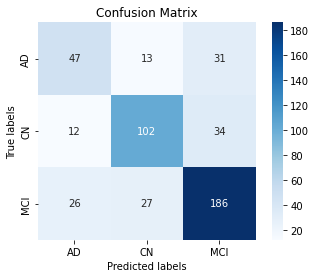

In [15]:
p = model05.predict(testing_image_datagen)
predicted_lab = p.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')

In [17]:
%load_ext tensorboard
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [12]:
EPOCH =70

Epoch 1/70


2024-03-31 20:01:49.801362: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


476/476 [==============================] - 195s 388ms/step - loss: 10.6856 - Accuracy: 0.4671 - AD_Precision: 0.2466 - CN_Precision: 0.3351 - MCI_Precision: 0.5749 - AD_Recall: 0.1627 - CN_Recall: 0.2524 - MCI_Recall: 0.5569 - val_loss: 1.8871 - val_Accuracy: 0.3975 - val_AD_Precision: 0.0000e+00 - val_CN_Precision: 0.3562 - val_MCI_Precision: 0.6250 - val_AD_Recall: 0.0000e+00 - val_CN_Recall: 0.9459 - val_MCI_Recall: 0.2092
Epoch 2/70
476/476 [==============================] - 152s 320ms/step - loss: 1.0358 - Accuracy: 0.5445 - AD_Precision: 0.4176 - CN_Precision: 0.5038 - MCI_Precision: 0.6006 - AD_Recall: 0.1145 - CN_Recall: 0.2583 - MCI_Recall: 0.5949 - val_loss: 1.8364 - val_Accuracy: 0.5167 - val_AD_Precision: 0.0000e+00 - val_CN_Precision: 0.7500 - val_MCI_Precision: 0.5107 - val_AD_Recall: 0.0000e+00 - val_CN_Recall: 0.0608 - val_MCI_Recall: 0.9958
Epoch 3/70
476/476 [==============================] - 180s 378ms/step - loss: 0.8821 - Accuracy: 0.6202 - AD_Precision: 0.4851 - C

/apps/tensorflow/2.7.0/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


              precision    recall  f1-score   support

          AD       0.88      0.79      0.83        91
          CN       0.88      0.88      0.88       148
         MCI       0.87      0.90      0.89       239

    accuracy                           0.87       478
   macro avg       0.88      0.86      0.87       478
weighted avg       0.87      0.87      0.87       478



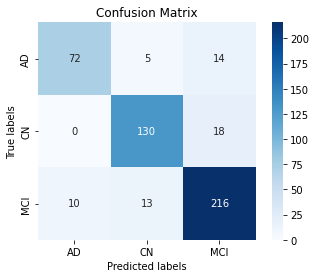

In [14]:
savepath = 'Finetuning/Resnet_70_0.0001/'
lr=0.0001
if not os.path.isdir(savepath):
      os.makedirs(savepath)
csvloger_callback = tf.keras.callbacks.CSVLogger(f'{savepath}history.csv', separator=',', append=False)

modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(savepath+'resnet50_row_10E-5_weights-epoch:{epoch:03d}-val_Accuracy:{val_Accuracy:.4f}.h5',monitor='val_Accuracy'
    ,verbose=0,save_best_only=True,save_weights_only=True,mode='max',save_freq='epoch' , initial_value_threshold=0.85)

OPT = tf.keras.optimizers.RMSprop(learning_rate=lr)
model04 = resnet50_row(OPT, LOOS,METRICS,image_Shape)
history04 = model04.fit(training_image_datagen, epochs=EPOCH, validation_data=testing_image_datagen,callbacks=[csvloger_callback,modelcheckpoint_callback])
model04 = resnet50_row(OPT, LOOS,METRICS,image_Shape)
model04.load_weights(glob.glob(f"{savepath}resnet50_row_10E-5_weights-epoch:*-val_Accuracy:{max(history04.history['val_Accuracy']):.4f}.h5")[0])
model04.save(f"{savepath}/Resnet_70_0.0001.h5")
p1 = model04.predict(testing_image_datagen)
predicted_lab = p1.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')
np.save("resnet_70_0.0001.npy",p1 )

Epoch 1/100


2024-04-01 11:33:32.082639: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


476/476 [==============================] - 81s 150ms/step - loss: 11.5112 - Accuracy: 0.4682 - AD_Precision: 0.2356 - CN_Precision: 0.3588 - MCI_Precision: 0.5760 - AD_Recall: 0.1596 - CN_Recall: 0.3010 - MCI_Recall: 0.5683 - val_loss: 1.6969 - val_Accuracy: 0.5000 - val_AD_Precision: 0.0000e+00 - val_CN_Precision: 0.0000e+00 - val_MCI_Precision: 0.5000 - val_AD_Recall: 0.0000e+00 - val_CN_Recall: 0.0000e+00 - val_MCI_Recall: 1.0000
Epoch 2/100
476/476 [==============================] - 67s 140ms/step - loss: 1.0604 - Accuracy: 0.5234 - AD_Precision: 0.2022 - CN_Precision: 0.4836 - MCI_Precision: 0.5886 - AD_Recall: 0.0542 - CN_Recall: 0.2583 - MCI_Recall: 0.5797 - val_loss: 1.6673 - val_Accuracy: 0.4519 - val_AD_Precision: 0.0000e+00 - val_CN_Precision: 0.4116 - val_MCI_Precision: 0.5581 - val_AD_Recall: 0.0000e+00 - val_CN_Recall: 0.9595 - val_MCI_Recall: 0.3013
Epoch 3/100
476/476 [==============================] - 69s 145ms/step - loss: 0.9248 - Accuracy: 0.5865 - AD_Precision: 0.4

/apps/tensorflow/2.7.0/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


              precision    recall  f1-score   support

          AD       0.94      0.64      0.76        91
          CN       0.92      0.84      0.88       148
         MCI       0.82      0.96      0.88       239

    accuracy                           0.86       478
   macro avg       0.89      0.81      0.84       478
weighted avg       0.87      0.86      0.86       478



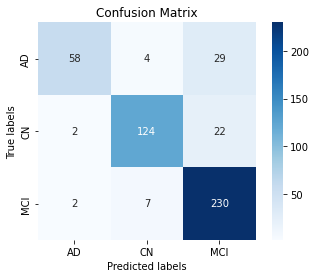

In [9]:
EPOCH =100
savepath = 'Finetuning/Resnet_100_0.0001/'
lr=0.0001
if not os.path.isdir(savepath):
      os.makedirs(savepath)
csvloger_callback = tf.keras.callbacks.CSVLogger(f'{savepath}history.csv', separator=',', append=False)

modelcheckpoint_callback = tf.keras.callbacks.ModelCheckpoint(savepath+'resnet50_row_10E-5_weights-epoch:{epoch:03d}-val_Accuracy:{val_Accuracy:.4f}.h5',monitor='val_Accuracy'
    ,verbose=0,save_best_only=True,save_weights_only=True,mode='max',save_freq='epoch' , initial_value_threshold=0.85)

OPT = tf.keras.optimizers.RMSprop(learning_rate=lr)
model04 = resnet50_row(OPT, LOOS,METRICS,image_Shape)
history04 = model04.fit(training_image_datagen, epochs=EPOCH, validation_data=testing_image_datagen,callbacks=[csvloger_callback,modelcheckpoint_callback])
model04 = resnet50_row(OPT, LOOS,METRICS,image_Shape)
model04.load_weights(glob.glob(f"{savepath}resnet50_row_10E-5_weights-epoch:*-val_Accuracy:{max(history04.history['val_Accuracy']):.4f}.h5")[0])
model04.save(f"{savepath}/Resnet_100_0.0001.h5")
p1 = model04.predict(testing_image_datagen)
predicted_lab = p1.argmax(axis=-1)
true_lab = testing_image_datagen.classes
plot_confusion_matrix(true_lab, predicted_lab, testing_image_datagen.class_indices.keys(),savepath)
report = classification_report(true_lab, predicted_lab, target_names=testing_image_datagen.class_indices.keys())
print(report)
dump_text(report,f'{savepath}classification_report.txt')
np.save("resnet_100_0.0001.npy",p1 )